# Create sum and product kernels with exsisting kernels


### From time to time, out dataset might contain values and features that might be of different types or scales. For instance, a temperture dataset might have two features with one being the timestamp and the other being the reading. As a result, we might want to apply differnt kernels on these two features respectively, and use the combined kernel for the drift detectors for a better test power.

In [1]:
import numpy as np
import scipy.stats as stats
import torch
import matplotlib.pyplot as plt
import tensorflow as tf

backend = 'tensorflow'

from alibi_detect.cd import MMDDrift
if backend == 'pytorch':
    from alibi_detect.utils.pytorch.kernels import GaussianRBF, Periodic
elif backend == 'tensorflow':
    from alibi_detect.utils.tensorflow.kernels import GaussianRBF, Periodic
else:
    raise ValueError('Backend {} not supported'.format(backend))

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_sin(N):
    c_0 = np.random.uniform(0, 168, N)
    x_0 = np.sin(c_0 / (12 / np.pi)) + np.random.normal(0, 0.1, N)

    c_1 = stats.beta.rvs(a=1.2, b=1.2, size=N) * 24 + np.random.choice([0, 24, 48, 72, 96, 120, 144], size=N)
    x_1 = np.sin(c_1 / (12 / np.pi)) * (np.mod(c_1, 24) < 12) + \
        np.sin(c_1 / (12 / np.pi)) * (np.mod(c_1, 24) >= 12) * 1.25 + \
            + np.random.normal(0, 0.1, N)
        
    x_ref = np.hstack([c_0.reshape(-1, 1), x_0.reshape(-1, 1)])
    x_test = np.hstack([c_1.reshape(-1, 1), x_1.reshape(-1, 1)])    
        
    return x_ref, x_test

In [3]:
x_ref, x_test = get_sin(N=1000)

### Here, we create two simple datasets with waves and have two features. The test data shows apparent drift around the wave through.

(-1.5, 1.5)

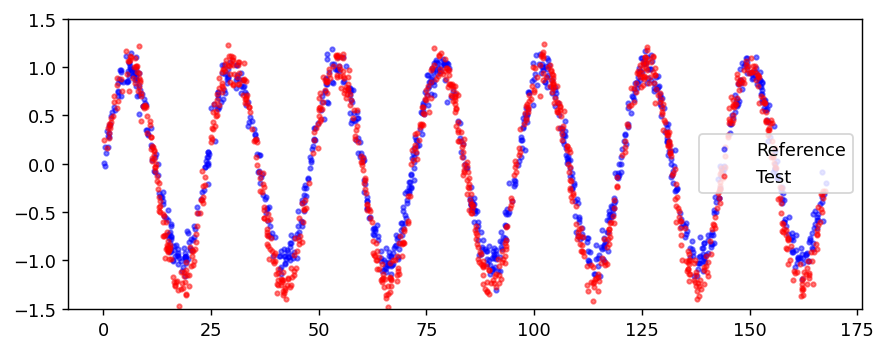

In [4]:
plt.figure(figsize=(8, 3), dpi=128)
plt.plot(x_ref[:, 0], x_ref[:, 1], 'bo', alpha=0.5, markersize=2.5, label='Reference')
plt.plot(x_test[:, 0], x_test[:, 1], 'ro', alpha=0.5, markersize=2.5, label='Test')
plt.legend()
plt.ylim(-1.5, 1.5)

### If we use the standard RBF kernel on both features with the MMD drift detector, we can see that the drift is not detected.

In [5]:
Kernel_RBF = GaussianRBF()

In [6]:
cd_RBF = MMDDrift(x_ref=x_ref,
                  backend=backend,
                  kernel=Kernel_RBF)

In [7]:
preds_RBF = cd_RBF.predict(x_test)
preds_RBF

{'data': {'is_drift': 0,
  'distance': -0.000772655,
  'p_val': 0.8,
  'threshold': 0.05,
  'distance_threshold': 0.0021861196},
 'meta': {'name': 'MMDDriftTF',
  'detector_type': 'offline',
  'data_type': None,
  'version': '0.9.2dev',
  'backend': 'tensorflow'}}

### To facilitate our knowledge that the data contain waves, we use a combined kernel averaged from two kernels. The first kernel is a periodic kernel with a specified period of 24 and only works on the first feature. The second kernel is an RBF kernel with an inferred bandwidth and only works on the second feature.

In [8]:
if backend == 'pytorch':
    Kernel_0 = Periodic(tau=torch.tensor([24.0]), active_dims=[0])
    Kernel_1 = GaussianRBF(active_dims=[1])
    Kernel_avg = (Kernel_0 + Kernel_1) / torch.tensor(2.0)
elif backend == 'tensorflow':
    Kernel_0 = Periodic(tau=tf.convert_to_tensor([24.0]), active_dims=[0])
    Kernel_1 = GaussianRBF(active_dims=[1])
    Kernel_avg = (Kernel_0 + Kernel_1) / tf.convert_to_tensor(2.0)

In [9]:
cd_avg = MMDDrift(x_ref=x_ref,
                  backend=backend,
                  kernel=Kernel_avg)

### We can see the drift is detected with the combined kernel.

In [10]:
preds_avg = cd_avg.predict(x_test)
preds_avg

{'data': {'is_drift': 1,
  'distance': 0.0052251816,
  'p_val': 0.0,
  'threshold': 0.05,
  'distance_threshold': 0.0009160042},
 'meta': {'name': 'MMDDriftTF',
  'detector_type': 'offline',
  'data_type': None,
  'version': '0.9.2dev',
  'backend': 'tensorflow'}}

### The kernel, its components and associated parameters can be inspected as follows:

In [11]:
print(cd_avg._detector.kernel)
print(cd_avg._detector.kernel.kernel_list[0].kernel_factors)
print(cd_avg._detector.kernel.kernel_list[1].kernel_factors)

ListWrapper([<alibi_detect.utils.tensorflow.kernels.Periodic object at 0x7f5ce9e4f490>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5>])
ListWrapper([<alibi_detect.utils.tensorflow.kernels.GaussianRBF object at 0x7f5ce9ebb730>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5>])


In [12]:
print(Kernel_avg.kernel_list[0].kernel_factors[0].tau)
print(Kernel_avg.kernel_list[0].kernel_factors[0].sigma)

tf.Tensor([24.], shape=(1,), dtype=float32)
tf.Tensor([34.68171], shape=(1,), dtype=float32)


In [13]:
print(Kernel_avg.kernel_list[1].kernel_factors[0].sigma)

tf.Tensor([0.5185638], shape=(1,), dtype=float32)
